# PRECISE HACKATHON: Breast Cancer Ultrasound Image Segmentation With Attention U-Net

**TEAM 3 LEAD: Philip Nkwam**

**Introduction & Motivation**<br>
Breast cancer is one of the most common cause of death among women worldwide. Early detecting significantly helps in reducing the consequences and number of deaths. Breast ultrasound images are basic data sources for medical staff to detect cancer tissue and prevent early death. These sonograms can produce great results in classification, detection, and segmentation of breast cancer when combined with machine learning.

In order to achieve efficient and accurate breast tumor recognition and diagnosis, this notebook proposes a breast tumor ultrasound image segmentation method based on Attention U-Net framework, a combination of U-Net and attention mechanism. The attention mechanism introduced into the image analysis model should improve the ability to obtain the feature information of ultrasound images and realize the accurate recognition and extraction of breast tumors.
### 1. Loading & Preprocessing Data

At this step, we will load the data (ultrasound images and their corresponding masks).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# check classes
# 0: normal
# 1: benign
# 2: malignant
directories = '/content/drive/MyDrive/PRECISE_Hackathon_Dataset'

unique_classes = []
for path in os.listdir(directories):
    unique_classes.append(path)

print('Unique classes:\n', unique_classes)

Unique classes:
 ['benign', 'normal', 'malignant']


The following code will extract mask metadata. We want to extract the shape of images. A function will detect the contours of tumors and return its widths and heights in pixels. This tabular result is not necessary for further analysis.

In [ ]:
import cv2
from pandas import DataFrame

def bounding_box_img(filepath):
    img = cv2.imread(filepath)
    height, width, channels = img.shape

    # detect metastasis contours: xmin, ymin, width, height
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    contours, hierarchy = cv2.findContours(gray, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[-2:]
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
    return (height, width, channels, x, y, w, h)

def extract_label(filepath):
    if 'benign' in filepath:
        return 'benign'
    else:
        return 'malignant'

# dictionary for storing metadata
dict_img = {'filename': [], 'img height': [], 'img width': [], 'img channels': [],
            'xmin': [], 'ymin': [], 'width': [], 'height': [], 'label': []}

def extract_metadata(file_dir):
    masks = sorted(os.listdir(file_dir))
    for f in masks:
        if 'mask' in f:
            full_path = os.path.join(file_dir, f)
            height, width, channels, x, y, w, h = bounding_box_img(full_path)

            # skip if no bounding box was found
            if x is not None:
                dict_img['filename'].append(f)
                dict_img['img height'].append(height)
                dict_img['img width'].append(width)
                dict_img['img channels'].append(channels)
                dict_img['xmin'].append(x)
                dict_img['ymin'].append(y)
                dict_img['width'].append(w)
                dict_img['height'].append(h)
                dict_img['label'].append(extract_label(f))

# run final function & generate dataframe
extract_metadata('/content/drive/MyDrive/PRECISE_Hackathon_Dataset/malignant/')
extract_metadata('/content/drive/MyDrive/PRECISE_Hackathon_Dataset/benign/')

df_img = DataFrame(dict_img)
df_img.head(500)

,filename,img height,img width,img channels,xmin,ymin,width,height,label
0,malignant (1)_mask.png,393,471,3,209,149,175,130,malignant
1,malignant (10)_mask.png,475,558,3,75,111,331,237,malignant
2,malignant (100)_mask.png,470,557,3,200,226,131,88,malignant
3,malignant (101)_mask.png,470,421,3,39,112,309,199,malignant
4,malignant (102)_mask.png,471,549,3,245,35,112,63,malignant
...,...,...,...,...,...,...,...,...,...
495,benign (358)_mask.png,575,689,3,125,105,124,80,benign
496,benign (359)_mask.png,581,772,3,237,134,101,70,benign
497,benign (36)_mask.png,468,561,3,227,121,60,48,benign
498,benign (360)_mask.png,458,549,3,182,50,292,179,benign


Some ultrasound images have assigned multiple masks: one tumor (metastasis) per mask. We want to generate new, single masks that contain multiple mask images (if they exist). These new overlayed masks will be then assigned to sonograms for semantic segmentation.

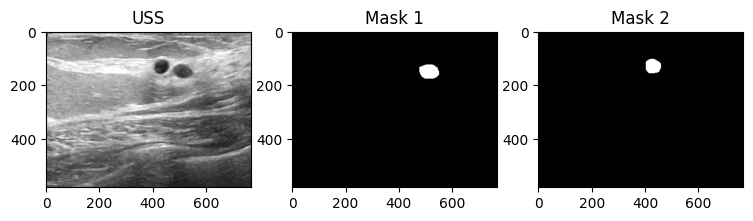

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# plot sonogram & masks
fig, axs = plt.subplots(1, 3, figsize=(9, 3))

image = Image.open('/content/drive/MyDrive/PRECISE_Hackathon_Dataset/benign/benign (15).png')
axs[0].imshow(image)
axs[0].set(title='USS')

image = Image.open('/content/drive/MyDrive/PRECISE_Hackathon_Dataset/benign/benign (15)_mask.png')
axs[1].imshow(image)
axs[1].set(title='Mask 1')

image = Image.open('/content/drive/MyDrive/PRECISE_Hackathon_Dataset/benign/benign (15)_mask_1.png')
axs[2].imshow(image)
axs[2].set(title='Mask 2')

plt.show()

In [ ]:
from glob import glob

def generate_single_masks(label):
    # set directory containing the mask images
    directory = f'/content/drive/MyDrive/PRECISE_Hackathon_Dataset/{label}/'

    # get all the mask files in the directory
    mask_files = glob(os.path.join(directory, '*_mask*.png'))

    # function to extract the base name from the file path
    def get_base_name(filepath):
        filename = os.path.basename(filepath)
        base_name = filename.split('_mask')[0]
        return base_name

    # group files by their base names
    mask_groups = {}
    for mask in mask_files:
        base_name = get_base_name(mask)
        if base_name not in mask_groups:
            mask_groups[base_name] = []
        mask_groups[base_name].append(mask)

    # create overlayed masks
    for base_name, files in mask_groups.items():
        # initialize an empty variable for the mask
        overlayed_mask = None

        for file in files:
            # load each mask image
            mask = cv2.imread(file, cv2.IMREAD_GRAYSCALE)

            if overlayed_mask is None:
                overlayed_mask = mask
            else:
                # overlay the current mask onto the accumulated mask
                overlayed_mask = cv2.add(overlayed_mask, mask)

        # save the new mask
        output_filename = os.path.join(directory, f'{base_name}_overlayed.png')
        cv2.imwrite(output_filename, overlayed_mask)
        #print(f'Saved overlayed mask: {output_filename}')

# run function
generate_single_masks(label='benign')
generate_single_masks(label='malignant')
generate_single_masks(label='normal') # these have plain masks but we need them renamed

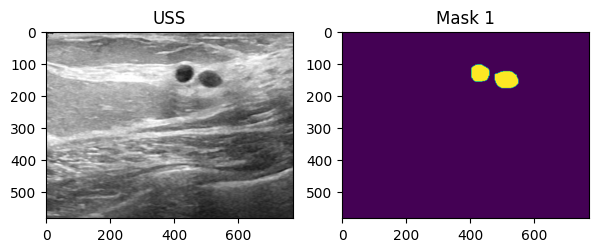

In [ ]:
# check results
fig, axs = plt.subplots(1, 2, figsize=(7, 3))

image = Image.open(r'/content/drive/MyDrive/PRECISE_Hackathon_Dataset/benign/benign (15).png')
axs[0].imshow(image)
axs[0].set(title='USS')

image = Image.open(r'/content/drive/MyDrive/PRECISE_Hackathon_Dataset/benign/benign (15)_overlayed.png')
axs[1].imshow(image)
axs[1].set(title='Mask 1')

plt.show()

In [ ]:
# optional code for deleting 'overlayed' files
# directory from where to delete the files
directory = '/content/drive/MyDrive/PRECISE_Hackathon_Dataset'

files_to_delete = glob(os.path.join(directory, '*overlayed*.png'))

# delete each file
for file in files_to_delete:
    try:
        os.remove(file)
        #print(f'Deleted: {file_path}')
    except OSError as e:
        print(f'Error deleting {file}: {e}')

The following function loads each file (image or mask) as a NumPy array and reshapes it to a unified 256 x 256 resolution. The function normalizes the arrays.

The converted images will be then stacked into two separate lists: images and masks. Finally, the lists of arrays will be divided into train and validation subsets with 80:20 ratio.

In [2]:
from tensorflow.image import resize
from keras.preprocessing.image import load_img, img_to_array
import numpy as np

# load images & convert to NumPy arrays
def load_images(image_paths, img_size=256, mask=False):
    # mask: 1 channel
    # image: 3 channels
    if mask:
        images = np.zeros(shape=(len(image_paths), img_size, img_size, 1))
    else:
        images = np.zeros(shape=(len(image_paths), img_size, img_size, 3))

    for i, image in enumerate(image_paths):
        img = np.round(resize(img_to_array(load_img(image))/255., (img_size, img_size)), 4)
        if mask:
            images[i] = img[:, :, :1]
        else:
            images[i] = img

    return images

In [10]:
root_path = r'/content/drive/My Drive/CAMERA/PRECISE_Hackathon/Hacakathon_Submission/Evaluation_dataset/'
unique_classes = ['benign', 'malignant', 'normal']

# set sorted paths into list
sorted_mask_paths = sorted([sorted(glob(root_path + name + '/*overlayed.png')) for name in unique_classes])

image_paths = []
mask_paths = []
for class_path in sorted_mask_paths:
    for path in class_path:
        img_path = path.replace('_overlayed', '')
        image_paths.append(img_path)
        mask_paths.append(path)

# convert images & masks
images = load_images(image_paths, img_size=256)
masks = load_images(mask_paths, img_size=256, mask=True)

print('Number of samples:', len(images))
print('Image shape:', images[0].shape, ', Mask shape:', masks[0].shape)

NameError: name 'glob' is not defined

In [ ]:
from sklearn.model_selection import train_test_split

# split dataset into 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.20, random_state=42)

print('Training samples:', len(X_train))
print('Testing samples:', len(X_test))

Training samples: 600
Testing samples: 150


### 2. Visualizing Dataset

A few samples of the images and their masks will be plotted.

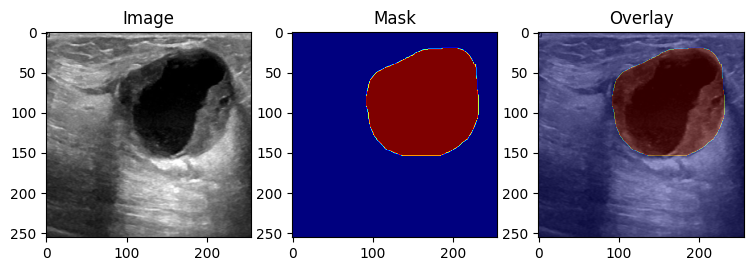

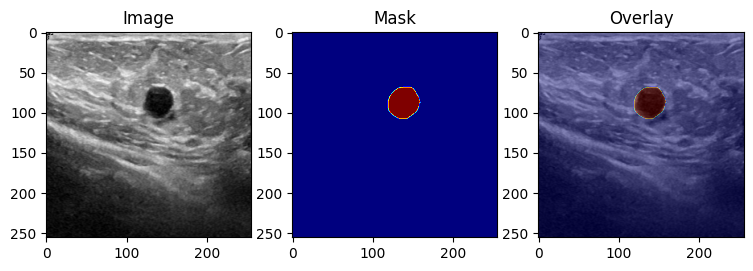

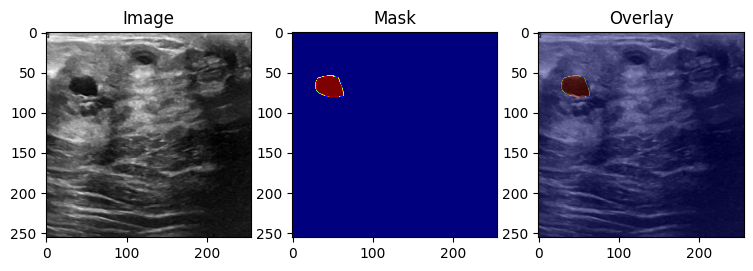

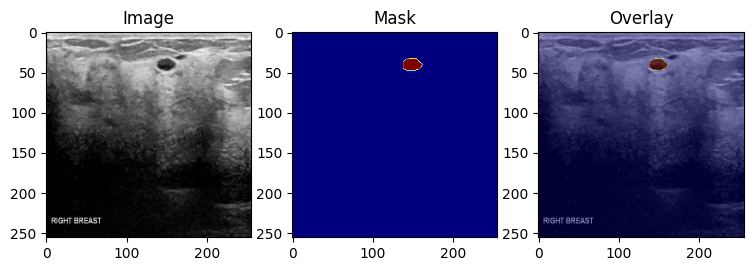

In [ ]:
def visualize_dataset(idx):
    fig, axs = plt.subplots(1, 3, figsize=(9, 3))

    axs[0].imshow(images[idx])
    axs[0].set(title='Image')

    axs[1].imshow(masks[idx], cmap='jet')
    axs[1].set(title='Mask')

    axs[2].imshow(images[idx])
    axs[2].imshow(masks[idx], cmap='jet', alpha=0.4)
    axs[2].set(title='Overlay')

    plt.show()

for i in [387, 52, 167, 32]:
    visualize_dataset(idx=i)

The Attention U-Net is an improved version of the U-Net model that uses special mechanisms called "attention gates" to focus better on the most important parts of an image. This is especially helpful for tasks like medical imaging, where we need to carefully identify areas of interest, such as tumors, and ignore irrelevant background details. The attention gates help the model automatically zoom in on the critical regions, like the tumors, while ignoring everything else.

This approach eliminates the need for extra complex steps that other models might require to pinpoint the exact location of a tissue or organ. By using attention, the model becomes more accurate and sensitive to tiny details in the images, improving its ability to spot unhealthy tissue (such as cancer) compared to healthy tissue. What's great is that this added focus doesn't slow down the model or require much more computing power.

We'll define these attention gates, along with the other parts of the model that process and reconstruct the images, as separate components. Together, they form the full network that we will train for 25 rounds. Since we’re trying to tell the difference between cancerous and healthy tissues in the images, the model will be trained using a method called binary cross-entropy, which helps the model learn to make this distinction accurately.

In [2]:
from tensorflow.keras.layers import Layer, Input, Conv2D, Dropout, MaxPool2D, UpSampling2D
from tensorflow.keras.layers import concatenate, Add, Multiply, BatchNormalization
from tensorflow.keras.models import Model

# define encoder
class EncoderBlock(Layer):
    def __init__(self, filters, rate, pooling=True, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate
        self.pooling = pooling

        self.c1 = None
        self.drop = None
        self.c2 = None
        self.pool = None if not pooling else MaxPool2D()

    def build(self, input_shape):
        self.c1 = Conv2D(self.filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.drop = Dropout(self.rate)
        self.c2 = Conv2D(self.filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')

        super(EncoderBlock, self).build(input_shape)

    def call(self, X):
        x = self.c1(X)
        x = self.drop(x)
        x = self.c2(x)
        if self.pooling:
            y = self.pool(x)
            return y, x
        else:
            return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config, 'filters': self.filters,
            'rate': self.rate, 'pooling': self.pooling
        }

# define decoder
class DecoderBlock(Layer):
    def __init__(self, filters, rate, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate

        self.up = UpSampling2D()
        self.net = EncoderBlock(filters, rate, pooling=False)

    def call(self, X):
        X, skip_X = X
        x = self.up(X)
        c_ = concatenate([x, skip_X])
        x = self.net(c_)
        return x

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, 'filters': self.filters, 'rate': self.rate}

# define attention gate
class AttentionGate(Layer):
    def __init__(self, filters, bn, **kwargs):
        super(AttentionGate, self).__init__(**kwargs)

        self.filters = filters
        self.bn = bn

        self.normal = Conv2D(filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
        self.down = Conv2D(filters, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer='he_normal')
        self.learn = Conv2D(1, kernel_size=1, padding='same', activation='sigmoid')
        self.resample = UpSampling2D()
        self.BN = BatchNormalization()

    def call(self, X):
        X, skip_X = X

        x = self.normal(X)
        skip = self.down(skip_X)
        x = Add()([x, skip])
        x = self.learn(x)
        x = self.resample(x)
        f = Multiply()([x, skip_X])
        if self.bn:
            return self.BN(f)
        else:
            return f

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, 'filters': self.filters, 'bn': self.bn}

In [4]:
def attention_unet_mod(img_height=256, img_width=256, img_channels=3):
    # input layer
    inputs = Input(shape=(img_height, img_width, img_channels))

    # encoder block
    p1, c1 = EncoderBlock(32, rate=0.1, name='Encoder_1')(inputs)
    p2, c2 = EncoderBlock(64, rate=0.1, name='Encoder_2')(p1)
    p3, c3 = EncoderBlock(128, rate=0.2, name='Encoder_3')(p2)
    p4, c4 = EncoderBlock(256, rate=0.2, name='Encoder_4')(p3)

    # encoding
    encoding = EncoderBlock(512, 0.3, pooling=False, name='Encoding')(p4)

    # attention gate + decoder block
    a1 = AttentionGate(256, bn=True, name='Attention_1')([encoding, c4])
    d1 = DecoderBlock(256, rate=0.2, name='Decoder_1')([encoding, a1])

    a2 = AttentionGate(128, bn=True, name='Attention_2')([d1, c3])
    d2 = DecoderBlock(128, rate=0.2, name='Decoder_2')([d1, a2])

    a3 = AttentionGate(64, bn=True, name='Attention_3')([d2, c2])
    d3 = DecoderBlock(64, rate=0.1, name='Decoder_3')([d2, a3])

    a4 = AttentionGate(32, bn=True, name='Attention_4')([d3, c1])
    d4 = DecoderBlock(32, rate=0.1, name='Decoder_4')([d3, a4])

    # output layer
    outputs = Conv2D(1, kernel_size=1, activation='sigmoid', padding='same')(d4)

    model = Model(inputs=[inputs], outputs=[outputs], name='Attention_U-Net')
    return model

att_model = attention_unet_mod()
att_model.summary()

Model: "Attention_U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Encoder_1 (EncoderBlock)  │ [(None, 128, 128, 32), │         10,144 │ input_layer[0][0]      │
│                           │ (None, 256, 256, 32)]  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Encoder_2 (EncoderBlock)  │ [(None, 64, 64, 64),   │         55,424 │ Encoder_1[0][0]        │
│                           │ (None, 128, 128, 64)]  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Encoder_3 (EncoderBlock)  │ [(None, 32, 32, 128),  │        221,440 │ Encoder_2[0][0]        │
│                           │ (None, 64, 64, 128)]   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Encoder_4 (EncoderBlock)  │ [(None, 16, 16, 256),  │        885,248 │ Encoder_3[0][0]        │
│                           │ (None, 32, 32, 256)]   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Encoding (EncoderBlock)   │ (None, 16, 16, 512)    │      3,539,968 │ Encoder_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Attention_1               │ (None, 32, 32, 256)    │      1,771,265 │ Encoding[0][0],        │
│ (AttentionGate)           │                        │                │ Encoder_4[0][1]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Decoder_1 (DecoderBlock)  │ (None, 32, 32, 256)    │      2,359,808 │ Encoding[0][0],        │
│                           │                        │                │ Attention_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Attention_2               │ (None, 64, 64, 128)    │        443,265 │ Decoder_1[0][0],       │
│ (AttentionGate)           │                        │                │ Encoder_3[0][1]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Decoder_2 (DecoderBlock)  │ (None, 64, 64, 128)    │        590,080 │ Decoder_1[0][0],       │
│                           │                        │                │ Attention_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Attention_3               │ (None, 128, 128, 64)   │        111,041 │ Decoder_2[0][0],       │
│ (AttentionGate)           │                        │                │ Encoder_2[0][1]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Decoder_3 (DecoderBlock)  │ (None, 128, 128, 64)   │        147,584 │ Decoder_2[0][0],       │
│                           │                        │                │ Attention_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Attention_4               │ (None, 256, 256, 32)   │         27,873 │ Decoder_3[0][0],       │
│ (AttentionGate)           │                        │                │ Encoder_1[0][1]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Decoder_4 (DecoderBlock)  │ (None, 256, 256, 32)   │         36,928 │ Decoder_3[0][0],       │
│                      

 Total params: 10,200,101 (38.91 MB)

 Trainable params: 10,199,141 (38.91 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 43s 265ms/step - IoU: 0.5118 - accuracy: 0.9890 - dice_coefficient: 0.9097 - loss: 0.0240 - val_IoU: 0.4874 - val_accuracy: 0.9634 - val_dice_coefficient: 0.6794 - val_loss: 0.1312
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 221ms/step - IoU: 0.5035 - accuracy: 0.9867 - dice_coefficient: 0.8800 - loss: 0.0311 - val_IoU: 0.5489 - val_accuracy: 0.9586 - val_dice_coefficient: 0.6765 - val_loss: 0.1714
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 223ms/step - IoU: 0.5478 - accuracy: 0.9891 - dice_coefficient: 0.9080 - loss: 0.0241 - val_IoU: 0.5104 - val_accuracy: 0.9652 - val_dice_coefficient: 0.6722 - val_loss: 0.1756
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 224ms/step - IoU: 0.5228 - accuracy: 0.9885 - dice_coefficient: 0.8964 - loss: 0.0258 - val_IoU: 0.5067 - val_accuracy: 0.9655 - val_dice_coefficient: 0.6992 - val_loss: 0.1554
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 219ms/step - IoU: 0.5102 - accuracy: 0.9882 - dice_coefficient: 0.9015 - loss

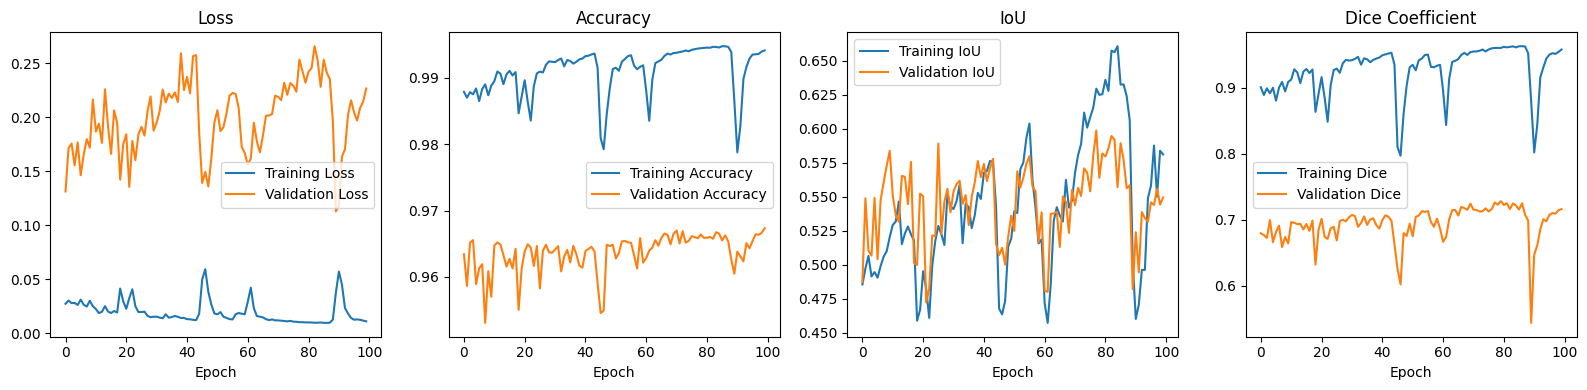

Final Validation Loss: 0.2267
Final Validation Accuracy: 0.9673
Final Validation IoU: 0.5495
Final Validation Dice Score: 0.7159
Calculated Validation Accuracy: 0.9684
Calculated Validation Dice Score: 0.7323


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping

def dice_coefficient(y_true, y_pred, smooth=1):
    y_true = K.cast(y_true, dtype='float32')
    y_pred = K.cast(y_pred, dtype='float32')
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def calculate_metrics(model, X_val, y_val):
    # Make predictions
    y_pred = model.predict(X_val)

    # Calculate accuracy
    y_pred_binary = (y_pred > 0.5).astype(np.uint8)
    y_val_binary = (y_val > 0.5).astype(np.uint8)
    accuracy = accuracy_score(y_val_binary.flatten(), y_pred_binary.flatten())

    # Calculate Dice score
    dice = dice_coefficient(y_val, y_pred).numpy()

    return accuracy, dice

# compile Attention U-Net model
att_model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.001, name='adam'),
    metrics=[MeanIoU(num_classes=2, name='IoU'), 'accuracy', dice_coefficient]
)

# define callbacks
csv_logger = CSVLogger('att_unet_history.txt', append=True, separator=',')

earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=7,
    mode='auto',
    verbose=1,
    restore_best_weights=True
)

# network training
history = att_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=8,
    verbose=1,
    callbacks=[csv_logger]
)

# Calculate final metrics
val_accuracy, val_dice = calculate_metrics(att_model, X_test, y_test)

# Plotting
plt.figure(figsize=(16, 4))

plt.subplot(1, 4, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 4, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 4, 3)
plt.plot(history.history['IoU'], label='Training IoU')
plt.plot(history.history['val_IoU'], label='Validation IoU')
plt.title('IoU')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 4, 4)
plt.plot(history.history['dice_coefficient'], label='Training Dice')
plt.plot(history.history['val_dice_coefficient'], label='Validation Dice')
plt.title('Dice Coefficient')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

# Display final metrics
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Final Validation IoU: {history.history['val_IoU'][-1]:.4f}")
print(f"Final Validation Dice Score: {history.history['val_dice_coefficient'][-1]:.4f}")
print(f"Calculated Validation Accuracy: {val_accuracy:.4f}")
print(f"Calculated Validation Dice Score: {val_dice:.4f}")

In [ ]:
# save model
att_model.save('attention_unet_mod.keras')

# display training results
df_results = DataFrame(history.history)
df_results.round(4)

,IoU,accuracy,dice_coefficient,loss,val_IoU,val_accuracy,val_dice_coefficient,val_loss
0,0.4855,0.9879,0.9007,0.0271,0.4874,0.9634,0.6794,0.1312
1,0.4974,0.9870,0.8890,0.0301,0.5489,0.9586,0.6765,0.1714
2,0.5066,0.9879,0.8991,0.0277,0.5104,0.9652,0.6722,0.1756
3,0.4915,0.9875,0.8916,0.0279,0.5067,0.9655,0.6992,0.1554
4,0.4946,0.9884,0.9000,0.0260,0.5492,0.9589,0.6657,0.1766
...,...,...,...,...,...,...,...,...
95,0.5582,0.9935,0.9501,0.0123,0.5459,0.9654,0.7073,0.2044
96,0.5877,0.9936,0.9523,0.0126,0.5440,0.9664,0.7098,0.1969
97,0.5500,0.9936,0.9513,0.0122,0.5558,0.9663,0.7091,0.2087
98,0.5838,0.9940,0.9543,0.0115,0.5442,0.9666,0.7142,0.2145


### 4. Attention U-Net Evaluation

The model has been trained and its performance will be evaluated. We will plot the learning curves to get an overall review of the learning process. Next, we will perform sample predictions.

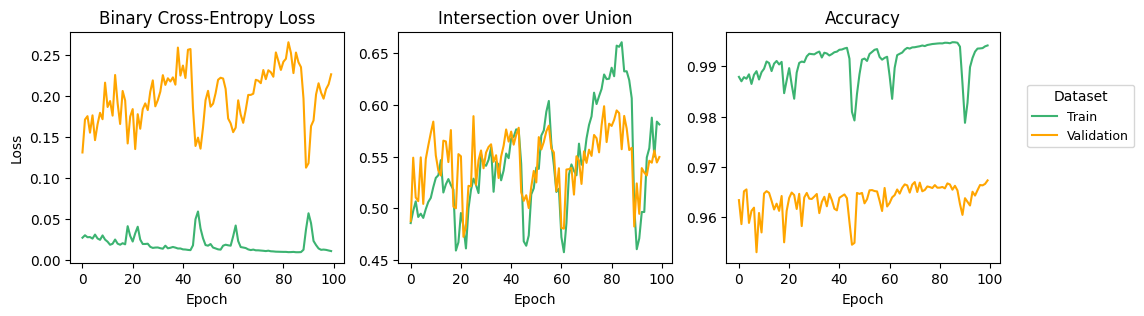

In [ ]:
# plot learning curves
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

ax[0].plot(history.history['loss'], color='mediumseagreen', label='Train')
ax[0].plot(history.history['val_loss'], color='orange', label='Validation')
ax[0].set(title='Binary Cross-Entropy Loss', xlabel='Epoch', ylabel='Loss')

ax[1].plot(history.history['IoU'], color='mediumseagreen', label='Train')
ax[1].plot(history.history['val_IoU'], color='orange', label='Validation')
ax[1].set(title='Intersection over Union', xlabel='Epoch', ylabel=None)

ax[2].plot(history.history['accuracy'], color='mediumseagreen', label='Train')
ax[2].plot(history.history['val_accuracy'], color='orange', label='Validation')
ax[2].set(title='Accuracy', xlabel='Epoch', ylabel=None)
ax[2].legend(loc=(1.1, 0.5), prop={'size': 9}, title='Dataset')

plt.show()

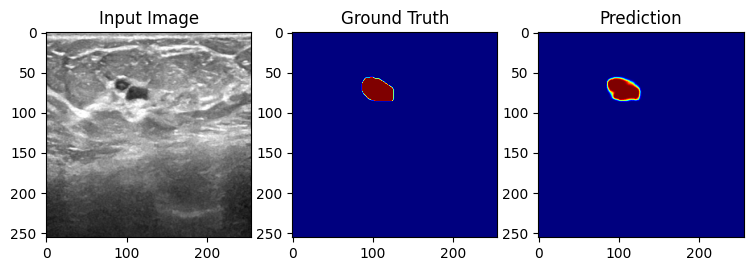

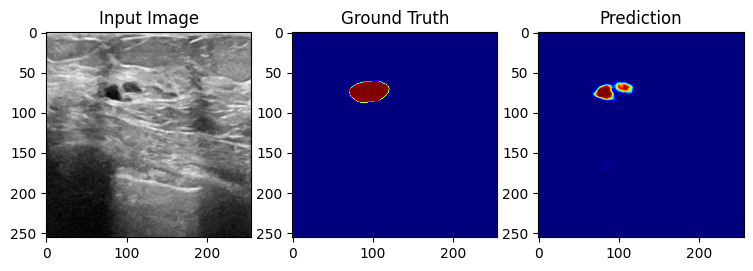

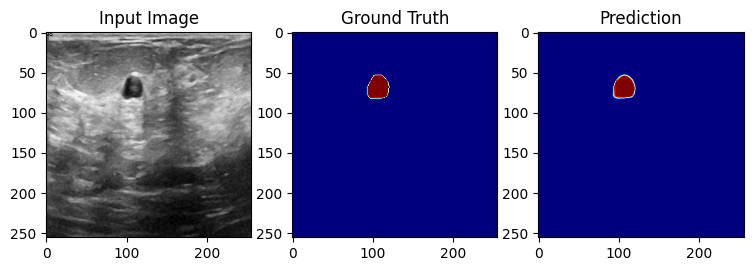

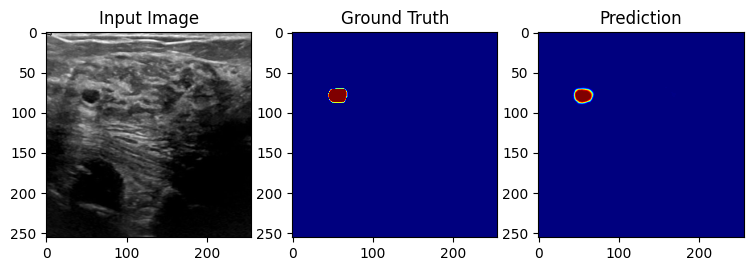

In [ ]:
from random import randint

# predict new mask & plot results
def generate_plot():
    # get random image index
    rand_number = randint(0, 150)
    image = images[rand_number]
    mask = masks[rand_number]

    # make prediction
    prediction = att_model.predict(image[np.newaxis, ...], verbose=0)

    # plot: input, mask, prediction
    fig, axs = plt.subplots(1, 3, figsize=(9, 4))

    axs[0].imshow(image)
    axs[0].set(title='Input Image')

    axs[1].imshow(mask, cmap='jet')
    axs[1].set(title='Ground Truth')

    axs[2].imshow(np.squeeze(prediction), cmap='jet')
    axs[2].set(title='Prediction')

    plt.show()

# perform predictions
for _ in range(0, 4):
    generate_plot()

# **INFERENCE SCRIPT AVAILABLE BELOW TO GENERATE NEW MASK(S)**
1. Feed folders containing images in "input_directory"
2. Specify output directory for generated masks
3. Mask is saved in output directory
4. Specify original image, mask and ground truth after segmentation

In [4]:
import os
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.image import resize
from tensorflow.keras.layers import Layer, Conv2D, Dropout, MaxPool2D, UpSampling2D
from tensorflow.keras.layers import concatenate, Add, Multiply, BatchNormalization
from keras.saving import register_keras_serializable
from tensorflow.keras import backend as K
import tensorflow as tf



@register_keras_serializable()
class EncoderBlock(Layer):
    def __init__(self, filters, rate, pooling=True, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.filters = filters
        self.rate = rate
        self.pooling = pooling
        self.c1 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.drop = Dropout(rate)
        self.c2 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.pool = MaxPool2D() if pooling else None

    def call(self, X):
        x = self.c1(X)
        x = self.drop(x)
        x = self.c2(x)
        if self.pooling:
            y = self.pool(x)
            return y, x
        else:
            return x

    def get_config(self):
        config = super().get_config()
        config.update({
            'filters': self.filters,
            'rate': self.rate,
            'pooling': self.pooling
        })
        return config

@register_keras_serializable()
class DecoderBlock(Layer):
    def __init__(self, filters, rate, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.filters = filters
        self.rate = rate
        self.up = UpSampling2D()
        self.net = EncoderBlock(filters, rate, pooling=False)

    def call(self, X):
        X, skip_X = X
        x = self.up(X)
        c_ = concatenate([x, skip_X])
        x = self.net(c_)
        return x

    def get_config(self):
        config = super().get_config()
        config.update({
            'filters': self.filters,
            'rate': self.rate
        })
        return config

@register_keras_serializable()
class AttentionGate(Layer):
    def __init__(self, filters, bn, **kwargs):
        super(AttentionGate, self).__init__(**kwargs)
        self.filters = filters
        self.bn = bn
        self.normal = Conv2D(filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
        self.down = Conv2D(filters, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer='he_normal')
        self.learn = Conv2D(1, kernel_size=1, padding='same', activation='sigmoid')
        self.resample = UpSampling2D()
        self.BN = BatchNormalization()

    def call(self, X):
        X, skip_X = X
        x = self.normal(X)
        skip = self.down(skip_X)
        x = Add()([x, skip])
        x = self.learn(x)
        x = self.resample(x)
        f = Multiply()([x, skip_X])
        if self.bn:
            return self.BN(f)
        else:
            return f

    def get_config(self):
        config = super().get_config()
        config.update({
            'filters': self.filters,
            'bn': self.bn
        })
        return config

def dice_coefficient(y_true, y_pred, smooth=1):
    y_true = K.cast(y_true, dtype='float32')
    y_pred = K.cast(y_pred, dtype='float32')
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


# Dice Coefficient Loss
def dice_coef_loss(inputs, target):
    smooth = 1e-6
    intersection = 2.0 * tf.reduce_sum(target * inputs) + smooth
    union = tf.reduce_sum(target) + tf.reduce_sum(inputs) + smooth
    return 1 - (intersection / union)

import torch
import torch.nn as nn

# Binary Cross-Entropy and Dice Loss
def bce_dice_loss(inputs, target):
    dice_score = dice_coef_loss(inputs, target)
    bce_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    bce_score = bce_loss(target, inputs)  # Note the order of arguments
    return bce_score + dice_score  # Combine the two losses

# Load the saved model
model = load_model('/content/drive/MyDrive/attention_unet_mod.keras', custom_objects={
    'EncoderBlock': EncoderBlock,
    'DecoderBlock': DecoderBlock,
    'AttentionGate': AttentionGate,
    'dice_coefficient': dice_coefficient
})

def load_and_preprocess_image(image_path, img_size=256):
    img = load_img(image_path)
    img_array = img_to_array(img)
    img_resized = resize(img_array, (img_size, img_size))
    img_normalized = img_resized / 255.0
    return img_normalized

def generate_segmentation(input_image_path, output_mask_path):
    # Load and preprocess the input image
    image = load_and_preprocess_image(input_image_path)
    # print("Image", image.shape)

    # Make prediction
    prediction = model.predict(np.expand_dims(image, axis=0), verbose=0)

    # Post-process the prediction
    mask = (prediction[0, :, :, 0] > 0.5).astype(np.uint8) * 255
    #print("mask", mask.shape)

    # Save the segmentation mask
    cv2.imwrite(output_mask_path, mask)

    return prediction[0, :, :, 0]

# Directory containing input images
input_directory = '/content/drive/My Drive/CAMERA/PRECISE_Hackathon/Hacakathon_Submission/Evaluation_dataset/'

# Directory to save output segmentation masks
output_directory = '/content/drive/My Drive/CAMERA/PRECISE_Hackathon/Hacakathon_Submission/Team_03'

# Create output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

import glob

masks = glob.glob("/content/drive/My Drive/CAMERA/PRECISE_Hackathon/Hacakathon_Submission/Evaluation_dataset/*/*_mask.png")
images = [mask_images.replace("_mask", "") for mask_images in masks]  # Replace "_mask" to get image paths
series = list(zip(images, masks))  # Zip image and mask paths together
# print(series)


# Process all images in the input directory
CNT = 0
for (images, masks) in series:

        ground_path = masks
        input_path = images
        #print(os.path.basename(input_path))
        output_path = os.path.join(output_directory, f'{os.path.basename(input_path.replace(".png", ""))}_mask.png')

        prediction = generate_segmentation(input_path, output_path)
        #print("prediction:",prediction.shape)

        ground_truth = load_and_preprocess_image(ground_path)
        ground_truth = ground_truth[:, :, 0]
        #print("ground_truth:",ground_truth.shape)

        #np.expand_dims(image, axis=0)

        # Calculate Dice score (assuming ground truth is available)
        # ground_truth = load_ground_truth(input_path)  # You need to implement this function
        dice_score = dice_coefficient(ground_truth, prediction).numpy()
        dice2 = dice_coef_loss(ground_truth, prediction).numpy()

        print(f"Processed {os.path.basename(input_path)[0]}, Dice Score: {dice_score:.4f}, Dice Score2: {dice2:.4f}")

        CNT += 1

        #print(f"Processed {filename}")


print(f"Segmentation complete for {CNT} images.")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'Encoder_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'Encoder_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'Encoder_3', however the layer does not have a

Processed n, Dice Score: 0.0003, Dice Score2: 1.0000
Processed n, Dice Score: 0.0151, Dice Score2: 1.0000
Processed n, Dice Score: 0.0028, Dice Score2: 1.0000
Processed n, Dice Score: 0.0282, Dice Score2: 1.0000
Processed n, Dice Score: 0.7739, Dice Score2: 1.0000
Processed n, Dice Score: 0.0074, Dice Score2: 1.0000
Processed n, Dice Score: 0.0002, Dice Score2: 1.0000
Processed n, Dice Score: 0.0035, Dice Score2: 1.0000
Processed n, Dice Score: 0.6312, Dice Score2: 1.0000
Processed n, Dice Score: 0.3723, Dice Score2: 1.0000
Processed b, Dice Score: 0.9717, Dice Score2: 0.0283
Processed b, Dice Score: 0.8413, Dice Score2: 0.1590
Processed b, Dice Score: 0.9401, Dice Score2: 0.0599
Processed b, Dice Score: 0.9405, Dice Score2: 0.0595
Processed b, Dice Score: 0.0020, Dice Score2: 0.9993
Processed b, Dice Score: 0.8860, Dice Score2: 0.1142
Processed b, Dice Score: 0.9349, Dice Score2: 0.0651
Processed b, Dice Score: 0.9068, Dice Score2: 0.0932
Processed b, Dice Score: 0.9310, Dice Score2: 

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(9, 4))

image = Image.open(r'/content/drive/MyDrive/USS/Some/Copy of malignant (194).png')
axs[0].imshow(image)
axs[0].set(title='Sonogram')

image = Image.open(r'/content/drive/MyDrive/USS/out/Copy of malignant (194)_mask.png')
axs[1].imshow(image)
axs[1].set(title='Mask 1')

image = Image.open(r'/content/drive/MyDrive/USS/malignant/malignant (194)_mask.png')
axs[2].imshow(image)
axs[2].set(title='Ground Truth')
plt.show()


# image = Image.open(r'/content/drive/MyDrive/USS/Some/Copy of malignant (210).png')
# axs[0].imshow(image)
# axs[0].set(title='Input Image')
# image = Image.open(r'/content/drive/MyDrive/USS/Some/Copy of malignant (210).png')
# axs[1].imshow(mask, cmap='jet')
# axs[1].set(title='Ground Truth')

# axs[2].imshow(np.squeeze(prediction), cmap='jet')
# axs[2].set(title='Prediction')

The segmentation network's learning curves display proper learning process. These sample predictions look accurate compared to their masks. The Attention U-Net network segments the cancer tissue correctly.

### 5. Conclusions

A breast tumor ultrasound image segmentation method based on Attention U-Net network was proposed. The U-Net network model is improved by introducing attention gates to upgrade the ability to obtain the feature information of sonograms and detect tumor structures within the tissue. The experimental results show that the proposed model can perform the analysis and determine cancer within ultrasound images. This method can provide reliable medical diagnosis assistance for physicians.


In [8]:
import torch
import os
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim.lr_scheduler as lr_scheduler
from PIL import Image
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import random
import cv2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

masks = glob.glob("/content/drive/My Drive/CAMERA/PRECISE_Hackathon/Hacakathon_Submission/TEAM_3/Team_03/*_grnd.png")
images = [mask_images.replace("_grnd", "") for mask_images in masks]  # Replace "_mask" to get image paths
series = list(zip(images, masks))  # Zip image and mask paths together

#print(series)



# Convert the image-mask pairs into a DataFrame for validation
validation_dataset_df = pd.DataFrame(series, columns=['image_path', 'mask_path'])


class CustomImageMaskDataset(Dataset):
    def __init__(self, dataframe, image_transform=None):
        self.data = dataframe  # DataFrame containing image and mask paths
        self.image_transform = image_transform  # Transformations

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get the image and mask paths
        image_path = self.data.iloc[idx]['image_path']
        mask_path = self.data.iloc[idx]['mask_path']

        # Load images and convert to grayscale
        image = Image.open(image_path).convert('L')
        mask = Image.open(mask_path).convert('L')

        # Apply transformations (if any)
        if self.image_transform:
            image = self.image_transform(image)
            mask = self.image_transform(mask)

        return image, mask

# Image transformations for validation
image_size = 128
val_transforms = transforms.Compose([
    transforms.Resize([image_size, image_size]),
    transforms.ToTensor(),  # Convert to Tensor
])

# Create validation dataset and dataloader
validation_dataset = CustomImageMaskDataset(validation_dataset_df, val_transforms)
batch_size = 16
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)



# Define Dice Coefficient Loss
def dice_coef_loss(inputs, target):
    smooth = 1e-6
    intersection = 2.0 * (target * inputs).sum() + smooth
    union = target.sum() + inputs.sum() + smooth
    return 1 - (intersection / union)

# Binary Cross-Entropy and Dice Loss
def bce_dice_loss(inputs, target):
    dice_score = dice_coef_loss(inputs, target)
    bce_loss = nn.BCELoss()  # Binary Cross-Entropy Loss
    bce_score = bce_loss(inputs, target)

    return bce_score + dice_score


def threshold_prediction(predicted, threshold=0.5):
    # Threshold predicted values
    predicted[predicted < threshold] = 0
    predicted[predicted >= threshold] = 1
    return predicted


# Function to evaluate the model on the validation dataset
def evaluate_model(dataloader, device):
    #model.eval()  # Set model to evaluation mode
    total_loss = 0
    dice_loss_total = 0

    with torch.no_grad():
        for batch in dataloader:
            # Load images and masks from the batch
            images, masks = batch
            images = images.to(device)
            masks = masks.to(device)

            # Get model predictions
            # outputs = model(images)

            # Threshold the predicted values
            #outputs = threshold_prediction(outputs, threshold=0.5)

            # Calculate Dice and BCE+Dice losses
            dice_loss = dice_coef_loss(images, masks)
            bce_dice = bce_dice_loss(images, masks)

            # Accumulate the total loss and dice loss
            total_loss += bce_dice.item()
            dice_loss_total += dice_loss.item()

    # Calculate average loss over the entire validation set
    avg_total_loss = total_loss / len(dataloader)
    avg_dice_loss = dice_loss_total / len(dataloader)

    return avg_total_loss, avg_dice_loss

# Evaluate the model on the validation dataset
avg_total_loss, avg_dice_loss = evaluate_model(validation_dataloader, device)

# Print the evaluation results
print(f"Average Total Loss (BCE + Dice): {avg_total_loss}")
print(f"Average Dice Loss: {avg_dice_loss}")

Average Total Loss (BCE + Dice): 2.39812433719635
Average Dice Loss: 0.3680221140384674
